In [1]:
!nvidia-smi

Sat Aug 15 18:27:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 38%   54C    P0    44W / 180W |      1MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import dependencies

In [2]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.core.display import display, HTML

import spacy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Example, Field, Dataset
from torchtext.data.iterator import BucketIterator
from torchtext.data.metrics import bleu_score

import warnings

import utils
import torch_utils

In [3]:
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

Device: cuda


## Load & clean data

In [4]:
%%time
data_fr = utils.read_file('./data/europarl-v7.fr-en.fr')
data_en = utils.read_file('./data/europarl-v7.fr-en.en')
print(f'Number of FR sentences: {len(data_fr):,}')
print(f'Number of EN sentences: {len(data_en):,}')

Number of FR sentences: 2,007,723
Number of EN sentences: 2,007,723
CPU times: user 1.76 s, sys: 825 ms, total: 2.59 s
Wall time: 2.58 s


In [5]:
data_fr = utils.clean_lines(data_fr)
data_en = utils.clean_lines(data_en)

100%|██████████| 2007723/2007723 [00:59<00:00, 33484.26it/s]


In [6]:
pairs = [*zip(data_fr, data_en)]
pairs = [*map(lambda x: {'fr': x[0], 'en': x[1]}, pairs)]
print(f'Number of examples: {len(pairs):,}')

Number of examples: 2,007,723


## Build datasets

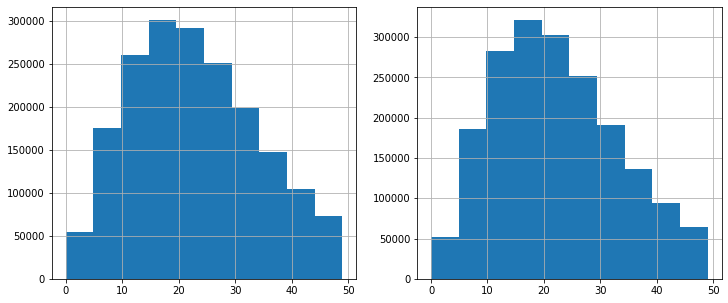

In [7]:
len_fr = [*map(lambda pair: len(pair['fr'].split()), pairs)]
len_en = [*map(lambda pair: len(pair['en'].split()), pairs)]

_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist([*filter(lambda x: x < 50, len_fr)])
axes[0].grid(True)
axes[1].hist([*filter(lambda x: x < 50, len_en)])
axes[1].grid(True)
plt.show()

In [8]:
%%time
MIN_LENGTH, MAX_LENGTH = 5, 10
pairs = [*filter(lambda pair: MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH and MIN_LENGTH <= len(pair['fr'].split()) <= MAX_LENGTH, pairs)]
print(f'Number of examples after filtering: {len(pairs):,}')

Number of examples after filtering: 221,823
CPU times: user 4.23 s, sys: 3.68 ms, total: 4.23 s
Wall time: 4.23 s


In [9]:
FR = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='fr',
           include_lengths=True)
EN = Field(init_token='<sos>',
           eos_token='<eos>',
           lower=True,
           tokenize='spacy',
           tokenizer_language='en',
           include_lengths=True)

examples = [Example.fromdict(
    data=pair,
    fields={
        'fr': ('src', FR),
        'en': ('dest', EN)
    }
) for pair in tqdm.tqdm(pairs)]
print(f'Number of examples: {len(examples):,}')

100%|██████████| 221823/221823 [00:34<00:00, 6521.32it/s]

Number of examples: 221,823


In [10]:
data = Dataset(examples, fields={'src': FR, 'dest': EN})
train_data, valid_data, test_data = data.split(split_ratio=[0.8, 0.1, 0.1])
print(f'train set size: {len(train_data.examples):,}')
print(f'valid set size: {len(valid_data.examples):,}')
print(f'test set size: {len(test_data.examples):,}')
print(vars(train_data.examples[0]))

train set size: 177,458
valid set size: 22,183
test set size: 22,182
{'src': ['evidemment', 'il', 'y', 'en', 'a', 'eu', 'beaucoup', 'plus'], 'dest': ['clearly', 'there', 'have', 'been', 'many', 'more']}


## Build vocabularies

In [11]:
MIN_COUNT = 5
FR.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
EN.build_vocab(train_data,
               min_freq=MIN_COUNT,
               specials=['<sos>', '<eos>', '<unk>', '<pad>'])
print(f'Length of FR vocabulary: {len(FR.vocab):,}')
print(f'Length of EN vocabulary: {len(EN.vocab):,}')

Length of FR vocabulary: 11,794
Length of EN vocabulary: 8,765


## Modeling

### Encoder model

In [12]:
class EncoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(EncoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
    
    def forward(self, input_sequences, sequence_lengths):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            
        :return
            outputs: Tensor[seq_len, batch_size, 2 * hidden_size]
            hn: Tensor[n_layers * 2, batch_size, hidden_size]
            cn: Tensor[n_layers * 2, batch_size, hidden_size]
        """
        embedded = self.embedding(input_sequences)
        embedded = F.dropout(embedded, p=self.dropout)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, sequence_lengths)
        outputs, (hn, cn) = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        return outputs, hn, cn

In [13]:
def test_encoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.35,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        outputs, hn, cn = encoder(
            input_sequences=data.src[0],
            sequence_lengths=data.src[1]
        )
        seq_len = data.src[0].size(0)
        assert outputs.size() == torch.Size([seq_len, batch_size, 2 * 256]), outputs.size()
        assert hn.size() == torch.Size([4 * 2, batch_size, 256]), hn.size()
        assert cn.size() == torch.Size([4 * 2, batch_size, 256]), cn.size()
        break
    
test_encoder()

### Decoder model

In [14]:
class DecoderLSTM(nn.Module):
    
    def __init__(
        self,
        embedding_size,
        vocab_size,
        hidden_size,
        n_layers,
        dropout,
        recurrent_dropout
    ):
        super(DecoderLSTM, self).__init__()
        self.embedding_size = embedding_size
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)
        
    def fine_tuning_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune
        
    def forward(self, input_word_index, h_state, c_state):
        """
        :params
            input_word_index: Tensor[batch_size,]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
            
        :return
            logit: Tensor[batch_size, vocab_size]
            h_state: Tensor[num_layers, batch_size, hidden_size]
            c_state: Tensor[num_layers, batch_size, hidden_size]
        """
        embedded = self.embedding(input_word_index.unsqueeze(0))
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        logit = self.fc(F.dropout(outputs, p=self.dropout))
        logit = logit.squeeze(0)
        return logit, h_state, c_state

In [15]:
def test_decoder():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    for data in train_iterator:
        logit, h_state, c_state = decoder(
            input_word_index=data.dest[0][0],
            h_state=torch.rand(4, batch_size, 256),
            c_state=torch.rand(4, batch_size, 256)
        )
        assert logit.size() == torch.Size([batch_size, len(EN.vocab)]), logit.size()
        assert h_state.size() == torch.Size([4, batch_size, 256]), h_state.size()
        assert c_state.size() == torch.Size([4, batch_size, 256]), c_state.size()
        break
        
test_decoder()

### Sequence-to-sequence model

In [16]:
class SeqToSeqLSTM(nn.Module):
    
    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, \
            'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, \
            'Encoder and Decoder must have the same number of reccurrent hidden units'
        
        super(SeqToSeqLSTM, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.init_h0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers) 
        self.init_c0 = nn.Linear(decoder.n_layers * 2, decoder.n_layers)
        self.device = device
        
    def forward(self, src_sequences, src_lengths, dest_sequences, dest_lengths, tf_ratio):
        """
        :params
            src_sequences: Tensor[seq_len, batch_size]
            src_lengths: Tensor[batch_size,]
            dest_sequences: Tensor[seq_len, batch_size]
            dest_lengths: Tensor[batch_size,]
            tf_ratio: float
            
        :return
            logits: Tensor[max(decode_lengths), batch_size, vocab_size]
            sorted_dest_sequences: Tensor[seq_len, batch_size]
            sorted_decode_lengths: Tensor[batch_size,]
            sorted_indices: Tensor[batch_size,]
        """
        # Encoding
        _, h_state, c_state = self.encoder(
            input_sequences=src_sequences,
            sequence_lengths=src_lengths
        )
        # h_state: [n_layers * 2, batch_size, hidden_size]
        # c_state: [n_layers * 2, batch_size, hidden_size]
        
        # Sort the batch (dest) by decreasing lengths
        sorted_dest_lengths, sorted_indices = torch.sort(dest_lengths, dim=0, descending=True)
        sorted_dest_sequences = dest_sequences[:, sorted_indices]
        
        # Init hidden and memory states
        h_state = self.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        c_state = self.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
        h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
        
        # We won't decode at the <eos> position, since we've finished generating as soon as we generate <eos>
        # So, decoding lengths are actual lengths - 1
        sorted_decode_lengths = (sorted_dest_lengths - 1).tolist()
        
        # Decoding
        batch_size, last = dest_sequences.size(1), None
        logits = torch.zeros(max(sorted_decode_lengths), batch_size, self.decoder.vocab_size).to(self.device)
        for t in range(max(sorted_decode_lengths)):
            batch_size_t = sum([l > t for l in sorted_decode_lengths])
            if last is not None:
                if random.random() < tf_ratio:
                    in_ = last[:batch_size_t]
                else:
                    in_ = sorted_dest_sequences[t, :batch_size_t]
            else:
                in_ = sorted_dest_sequences[t, :batch_size_t]
            # in_ [batch_size,]
            logit, h_state, c_state = self.decoder(
                in_, 
                h_state[:, :batch_size_t, :].contiguous(),
                c_state[:, :batch_size_t, :].contiguous()
            )
            # logit: [batch_size, vocab_size]
            # h_state: [num_layers, batch_size, hidden_size]
            # c_state: [num_layers, batch_size, hidden_size]
            logits[t, :batch_size_t, :] = logit
            last = torch.argmax(F.softmax(logit, dim=1), dim=1) # [batch_size,]
        
        return logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices

In [17]:
def test_seq2seq():
    batch_size = 128
    train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=batch_size,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True)
    encoder = EncoderLSTM(
        embedding_size=300,
        vocab_size=len(FR.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    decoder = DecoderLSTM(
        embedding_size=300,
        vocab_size=len(EN.vocab),
        hidden_size=256,
        n_layers=4,
        dropout=0.25,
        recurrent_dropout=0.25
    )
    model = SeqToSeqLSTM(encoder, decoder, device='cpu')
    for data in train_iterator:
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(
                src_sequences=data.src[0], 
                src_lengths=data.src[1],
                dest_sequences=data.dest[0],
                dest_lengths=data.dest[1],
                tf_ratio=0.
            )
        assert logits.size() == torch.Size([
            max(sorted_decode_lengths),
            batch_size,
            len(EN.vocab)
        ]), logits.size()
        assert sorted_dest_sequences.size() == torch.Size([
            data.dest[0].shape[0],
            batch_size
        ]), sorted_dest_sequences.size()
        assert len(sorted_decode_lengths) == batch_size, len(sorted_decode_lengths)
        assert sorted_indices.size() == torch.Size([
            batch_size,
        ]), sorted_indices.size()
        break
        
test_seq2seq()

### Training routines

In [18]:
def train_step(model, optimizer, criterion, loader, epoch, grad_clip, tf_ratio, device):
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.train()
    pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
    for i, data in pbar:
        # Forward prop.
        logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
            model(*data.src, *data.dest, tf_ratio=tf_ratio)
        # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
        sorted_dest_sequences = sorted_dest_sequences[1:, :]
        # Remove paddings
        logits = nn.utils.rnn.pack_padded_sequence(
            logits,
            sorted_decode_lengths
        ).data
        sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
            sorted_dest_sequences,
            sorted_decode_lengths
        ).data
        # Calculate loss
        loss = criterion(logits, sorted_dest_sequences)
        # Back prop.
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients
        if grad_clip is not None:
            torch_utils.clip_gradient(optimizer, grad_clip)
        # Update weights
        optimizer.step()
        # Track metrics
        loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
        acc_tracker.update(
            torch_utils.accuracy(logits, sorted_dest_sequences, 1),
            sum(sorted_decode_lengths)
        )
        # Update progressbar description
        pbar.set_description(f'Epoch: {epoch + 1:03d} - loss: {loss_tracker.average:.3f} - acc: {acc_tracker.average:.3f}%')
    return loss_tracker.average, acc_tracker.average

In [19]:
def validate(model, criterion, loader, field, epoch, device):
    references, hypotheses = [], []
    loss_tracker, acc_tracker = utils.AverageMeter(), utils.AverageMeter()
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar: 
            # Forward prop.
            logits, sorted_dest_sequences, sorted_decode_lengths, sorted_indices = \
                model(*data.src, *data.dest, tf_ratio=0.)
            # Since we decoded starting with <sos>, the targets are all words after <sos>, up to <eos>
            sorted_dest_sequences = sorted_dest_sequences[1:, :]
            # Remove paddings
            logits_copy = logits.clone()
            logits = nn.utils.rnn.pack_padded_sequence(
                logits,
                sorted_decode_lengths
            ).data
            sorted_dest_sequences = nn.utils.rnn.pack_padded_sequence(
                sorted_dest_sequences,
                sorted_decode_lengths
            ).data
            # Calculate loss
            loss = criterion(logits, sorted_dest_sequences)
            # Track metrics
            loss_tracker.update(loss.item(), sum(sorted_decode_lengths))
            acc_tracker.update(
                torch_utils.accuracy(logits, sorted_dest_sequences, 1),
                sum(sorted_decode_lengths)
            )
            # Update references
            target_sequences = data.dest[0].t()[sorted_indices]
            for j in range(target_sequences.size(0)):
                target_sequence = target_sequences[j].tolist()
                reference = [
                    field.vocab.itos[indice] 
                    for indice in target_sequence 
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                references.append([reference])
            # Update hypotheses
            _, preds = torch.max(logits_copy, dim=2)
            preds = preds.t().tolist()
            for j, p in enumerate(preds):
                hypotheses.append([
                    field.vocab.itos[indice] 
                    for indice in preds[j][:sorted_decode_lengths[j]] # Remove padding
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ])
            assert len(references) == len(hypotheses)
            # Update progressbar description
            pbar.set_description(f'Epoch: {epoch + 1:03d} - val_loss: {loss_tracker.average:.3f} - val_acc: {acc_tracker.average:.3f}%')
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
        # Display some examples
        for i in np.random.choice(len(loader), 3):
            src, dest = ' '.join(references[i][0]), ' '.join(hypotheses[i])
            display(HTML(f'<span style="color:blue"><b>Ground truth translation:</b> {src}</span>'))
            display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {dest}</span>'))
            print('='*100)
    return loss_tracker.average, acc_tracker.average, bleu4

In [20]:
def train(model, optimizer, criterion, train_loader, valid_loader, field, n_epochs, grad_clip, tf_ratio, last_improv, model_name, device):
    history, best_bleu = {
        'acc': [],
        'loss': [],
        'val_acc': [],
        'val_loss': [],
        'bleu4': []
    }, 0.
    for epoch in range(n_epochs):
         # Stop training if no improvment since last 4 epochs
        if last_improv == 4:
            print('Training Finished - The model has stopped improving since last 4 epochs')
            break
        # Decay LR if no improvment
        if last_improv > 0:
            torch_utils.adjust_lr(optimizer=optimizer,
                                  shrink_factor=0.9,
                                  verbose=True)
        # Train step
        loss, acc = train_step(model=model,
                               optimizer=optimizer,
                               criterion=criterion,
                               loader=train_loader,
                               epoch=epoch,
                               grad_clip=grad_clip, 
                               tf_ratio=tf_ratio,
                               device=device)
        # Validation step
        val_loss, val_acc, bleu4 = validate(model=model,
                                            criterion=criterion,
                                            loader=valid_loader,
                                            field=field,
                                            epoch=epoch,
                                            device=device)
        # Update history dict
        history['acc'].append(acc)
        history['loss'].append(loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        history['bleu4'].append(bleu4)
        # Print BLEU score
        text = f'BLEU-4: {bleu4*100:.3f}%'
        if bleu4 > best_bleu:
            best_bleu, last_improv = bleu4, 0
        else:
            last_improv += 1
            text += f' - Last improvement since {last_improv} epoch(s)'
        print(text)
        # Decrease teacher forcing rate
        tf_ratio = torch_utils.adjust_tf(tf_ratio,
                                         shrink_factor=0.8,
                                         verbose=False)
        # Save checkpoint
        torch_utils.save_checkpoint(model=model,
                                    optimizer=optimizer,
                                    data_name=model_name,
                                    epoch=epoch,
                                    last_improv=last_improv,
                                    bleu4=bleu4,
                                    is_best=bleu4 >= best_bleu)
    return history

### Init models

In [21]:
# Load word vectors
spacy_fr = spacy.load('fr_core_news_lg') # CBOW trained word vectors
spacy_en = spacy.load('en_core_web_lg') # GloVe trained word vectors

In [22]:
# Load embeddings
fr_embeddings = torch_utils.load_embeddings(nlp=spacy_fr, field=FR)
en_embeddings = torch_utils.load_embeddings(nlp=spacy_en, field=EN)

100%|██████████| 8781/8781 [01:15<00:00, 115.85it/s]


In [27]:
MODEL_NAME = 'seq2seq-lstm'
N_LAYERS = 1
HIDDEN_SIZE = 128
EMBEDDING_SIZE = 300
ENC_DROPOUT = 0.
ENC_RECURRENT_DROPOUT = 0.
DEC_DROPOUT = 0.
DEC_RECURRENT_DROPOUT = 0.
N_EPOCHS = 15
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
GRAD_CLIP = 1.0
TF_RATIO = 1.0

In [31]:
encoder = EncoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(FR.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=ENC_DROPOUT,
    recurrent_dropout=ENC_RECURRENT_DROPOUT
)
encoder.load_pretrained_embeddings(fr_embeddings)
encoder.fine_tuning_embeddings(fine_tune=False)
decoder = DecoderLSTM(
    embedding_size=EMBEDDING_SIZE,
    vocab_size=len(EN.vocab),
    hidden_size=HIDDEN_SIZE,
    n_layers=N_LAYERS,
    dropout=DEC_DROPOUT,
    recurrent_dropout=DEC_RECURRENT_DROPOUT
)
decoder.load_pretrained_embeddings(en_embeddings)
decoder.fine_tuning_embeddings(fine_tune=False)
seq2seq = SeqToSeqLSTM(encoder=encoder, decoder=decoder, device=DEVICE)
# seq2seq.apply(torch_utils.xavier_init_weights)
seq2seq.to(DEVICE)
optimizer = optim.RMSprop(params=seq2seq.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
print(f'Number of parameters of the model: {torch_utils.count_parameters(seq2seq):,}')

Number of parameters of the model: 1,791,171


### Training

In [32]:
train_iterator, valid_iterator, test_iterator =  \
        BucketIterator.splits((train_data, valid_data, test_data),
                              batch_size=BATCH_SIZE,
                              sort_key=lambda x: len(x.src),
                              sort_within_batch=True,
                              device=DEVICE)

In [33]:
history = train(model=seq2seq,
                optimizer=optimizer,
                criterion=criterion,
                train_loader=train_iterator,
                valid_loader=valid_iterator,
                field=EN,
                n_epochs=N_EPOCHS,
                grad_clip=GRAD_CLIP,
                tf_ratio=TF_RATIO,
                last_improv=0,
                model_name=MODEL_NAME,
                device=DEVICE)

Epoch: 001 - val_loss: 5.599 - val_acc: 1.017%: 100%|██████████| 347/347 [00:09<00:00, 36.99it/s]


BLEU-4: 0.000% - Last improvement since 1 epoch(s)


  0%|          | 0/2773 [00:00<?, ?it/s]


Decaying learning rate.
The new learning rate is 0.000900



Epoch: 002 - val_loss: 4.778 - val_acc: 1.587%: 100%|██████████| 347/347 [00:10<00:00, 34.17it/s]


BLEU-4: 3.230%


Epoch: 003 - val_loss: 4.475 - val_acc: 1.785%: 100%|██████████| 347/347 [00:09<00:00, 36.32it/s]


BLEU-4: 4.592%


Epoch: 004 - val_loss: 4.293 - val_acc: 1.895%: 100%|██████████| 347/347 [00:09<00:00, 36.47it/s]


BLEU-4: 5.164%


Epoch: 005 - val_loss: 4.169 - val_acc: 1.981%: 100%|██████████| 347/347 [00:09<00:00, 36.28it/s]


BLEU-4: 5.917%


Epoch: 006 - val_loss: 4.077 - val_acc: 2.056%: 100%|██████████| 347/347 [00:09<00:00, 36.93it/s]


BLEU-4: 6.919%


Epoch: 007 - val_loss: 4.007 - val_acc: 2.100%: 100%|██████████| 347/347 [00:09<00:00, 36.35it/s]


BLEU-4: 7.100%


Epoch: 008 - val_loss: 3.952 - val_acc: 2.142%: 100%|██████████| 347/347 [00:09<00:00, 37.39it/s]


BLEU-4: 7.574%


Epoch: 009 - val_loss: 3.911 - val_acc: 2.169%: 100%|██████████| 347/347 [00:10<00:00, 34.35it/s]


BLEU-4: 7.947%


Epoch: 010 - val_loss: 3.874 - val_acc: 2.205%: 100%|██████████| 347/347 [00:09<00:00, 36.45it/s]


BLEU-4: 8.213%


Epoch: 011 - val_loss: 3.851 - val_acc: 2.220%: 100%|██████████| 347/347 [00:09<00:00, 36.15it/s]


BLEU-4: 8.265%


Epoch: 012 - val_loss: 3.821 - val_acc: 2.239%: 100%|██████████| 347/347 [00:09<00:00, 37.09it/s]


BLEU-4: 8.421%


Epoch: 013 - val_loss: 3.819 - val_acc: 2.242%: 100%|██████████| 347/347 [00:09<00:00, 36.63it/s]


  0%|          | 0/2773 [00:00<?, ?it/s]

BLEU-4: 8.336% - Last improvement since 1 epoch(s)

Decaying learning rate.
The new learning rate is 0.000810



Epoch: 014 - val_loss: 3.794 - val_acc: 2.262%: 100%|██████████| 347/347 [00:09<00:00, 36.74it/s]


BLEU-4: 8.624%


Epoch: 015 - val_loss: 3.784 - val_acc: 2.272%: 100%|██████████| 347/347 [00:09<00:00, 36.63it/s]


BLEU-4: 8.712%


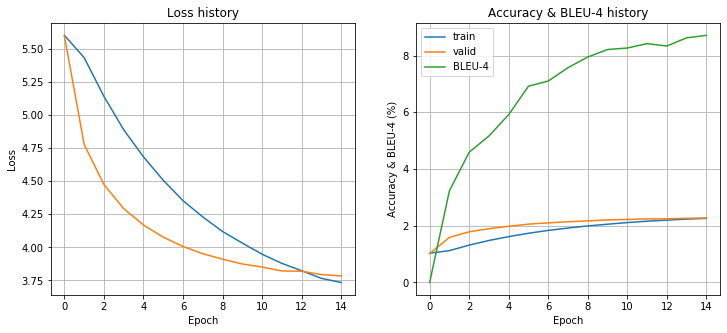

In [34]:
_, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(history['loss'], label='train')
axes[0].plot(history['val_loss'], label='valid')
axes[0].set_title('Loss history')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].grid(True)
axes[1].plot(history['acc'], label='train')
axes[1].plot(history['val_acc'], label='valid')
axes[1].plot(np.array(history['bleu4']) * 100., label='BLEU-4')
axes[1].set_title('Accuracy & BLEU-4 history')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy & BLEU-4 (%)')
axes[1].grid(True)
plt.legend()
plt.show()

### Evaluation

In [35]:
seq2seq.load_state_dict(torch.load(f'./checkpoint/BEST_{MODEL_NAME}.pt').get('model'))

<All keys matched successfully>

In [86]:
class Node:
    id_ = 0
    
    def __init__(self, token, states, logp=0., parent=None, eos=False):
        self.__id = self.__class__.id_
        self.__token = token
        self.__states = states
        self.__logp = logp
        self.__parent_id = None if parent is None else parent.id
        self.__eos = eos
        self.__level = 0 if parent is None else parent.level + 1
        self.__logps = logp if parent is None else parent.logps + logp
        self.__class__.id_ += 1
        
    def __str__(self):
        return f'Node[id={self.__id}, ' + \
                    f'logp={self.__logp}, ' + \
                    f'logps={self.__logps}, ' + \
                    f'parent_id={self.__parent_id}, ' + \
                    f'level={self.__level}]'
    
    @property
    def id(self):
        return self.__id
    
    @id.setter
    def id(self, id_):
        self.__id = id_
    
    @property
    def token(self):
        return self.__token
    
    @token.setter
    def token(self, token):
        self.__token = token
    
    @property
    def states(self):
        return self.__states
    
    @states.setter
    def states(self, states):
        self.__states = states
      
    @property
    def eos(self):
        return self.__eos
    
    @eos.setter
    def eos(self, eos):
        self.__eos = eos
    
    @property
    def logps(self):
        return self.__logps
    
    @logps.setter
    def logps(self, logps):
        self.__logps = logps
        
    @property
    def level(self):
        return self.__level
    
    @level.setter
    def level(self, level):
        self.__level = level

In [87]:
def evaluate(model, loader, beam_size, field, max_len, device):
    references, hypotheses = [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar:
            (src_sequences, src_lengths) = data.src[0], data.src[1]
            (dest_sequences, dest_lengths) = data.dest[0], data.dest[1]
            
            batch_size = src_sequences.shape[1]
            for j in range(batch_size): # We evaluate sentence by sentence
                src_sequence = src_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                dest_sequence = dest_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                src_length, dest_length = src_lengths[j, None], dest_lengths[j, None] # [1,]
                
                # Encoding
                _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                    sequence_lengths=src_length)
                
                # Init hidden and memory states
                h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                
                # Decoding
                tree = [[Node(
                    token=torch.LongTensor([
                        field.vocab.stoi[field.init_token]
                    ]).to(device),
                    states=(h_state, c_state)
                ) for _ in range(beam_size)]]
                print(tree)
                
                for _ in range(max_len):
                    next_nodes = []
                    for node in tree[-1]:
                        # Skip eos token
                        if node.eos:
                            continue
                        # Decode
                        logit, h_state, c_state = model.decoder(
                            input_word_index=node.token, 
                            h_state=node.states[0].contiguous(),
                            c_state=node.states[1].contiguous()
                        )
                        # logit: [1, vocab_size]
                        # h_state: [n_layers, 1, hidden_size]
                        # c_state: [n_layers, 1, hidden_size]

                        # Get scores
                        logp = F.log_softmax(logit, dim=1).squeeze(dim=0) # [vocab_size]

                        # Get top k tokens & logps
                        topk_logps, topk_tokens = torch.topk(logp, beam_size)

                        for k in range(beam_size):
                            next_nodes.append(Node(
                                token=topk_tokens[k, None],
                                states=(h_state, c_state),
                                logp=topk_logps[k, None],
                                parent=node,
                                eos=topk_tokens[k].cpu().item() == field.vocab[field.eos_token]
                            ))

                    
                    # Sort next_nodes to get the best
                    next_nodes = sorted(next_nodes,
                                        key=lambda node: node.logps,
                                        reverse=True)
                    # Update the tree
                    tree.append(next_nodes[:beam_size])
                
                # Find the best path of the tree
                # best = [tree[-1][0]]
                # for nodes in reversed(tree):
                #    for node in nodes:
                #        
                #    best.append(nodes[0])
                break
            break
    
    return tree, src_sequence, dest_sequence

In [88]:
tree, _, _ = evaluate(seq2seq.to(DEVICE),
                       loader=test_iterator,
                       beam_size=3,
                       field=EN,
                       max_len=MAX_LENGTH,
                       device=DEVICE)

  0%|          | 0/347 [00:00<?, ?it/s]

[[<__main__.Node object at 0x7f69527e33c8>, <__main__.Node object at 0x7f69527e32e8>, <__main__.Node object at 0x7f69527e3438>]]


In [93]:
[*map(lambda nodes: [*map(Node.__str__, nodes)], tree)]

[['Node[id=0, logp=0.0, logps=0.0, parent_id=None, level=0]',
  'Node[id=1, logp=0.0, logps=0.0, parent_id=None, level=0]',
  'Node[id=2, logp=0.0, logps=0.0, parent_id=None, level=0]'],
 ["Node[id=3, logp=tensor([-2.0521], device='cuda:0'), logps=tensor([-2.0521], device='cuda:0'), parent_id=0, level=1]",
  "Node[id=6, logp=tensor([-2.0521], device='cuda:0'), logps=tensor([-2.0521], device='cuda:0'), parent_id=1, level=1]",
  "Node[id=9, logp=tensor([-2.0521], device='cuda:0'), logps=tensor([-2.0521], device='cuda:0'), parent_id=2, level=1]"],
 ["Node[id=12, logp=tensor([-2.2469], device='cuda:0'), logps=tensor([-4.2990], device='cuda:0'), parent_id=3, level=2]",
  "Node[id=15, logp=tensor([-2.2469], device='cuda:0'), logps=tensor([-4.2990], device='cuda:0'), parent_id=6, level=2]",
  "Node[id=18, logp=tensor([-2.2469], device='cuda:0'), logps=tensor([-4.2990], device='cuda:0'), parent_id=9, level=2]"],
 ["Node[id=21, logp=tensor([-0.0953], device='cuda:0'), logps=tensor([-4.3943], de

In [90]:
[*map(lambda node: (node.logps, node.token), tree[-1])]

[]

In [36]:
def evaluate(model, loader, beam_size, field, max_len, device):
    references, hypotheses = [], []
    model.eval()
    with torch.no_grad():
        pbar = tqdm.tqdm(enumerate(loader), total=len(loader))
        for i, data in pbar:
            (src_sequences, src_lengths) = data.src[0], data.src[1]
            (dest_sequences, dest_lengths) = data.dest[0], data.dest[1]
            
            batch_size = src_sequences.shape[1]
            for j in range(batch_size): # We evaluate sentence by sentence
                src_sequence = src_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                dest_sequence = dest_sequences[:, j].unsqueeze(1) # [seq_len, 1]
                src_length, dest_length = src_lengths[j, None], dest_lengths[j, None] # [1,]
                
                k = beam_size
                # Top k previous token indices at each step
                topk_prev_tokens = torch.LongTensor([
                    [field.vocab.stoi[field.init_token]]
                ] * k).to(device)  # [k, 1]
                # Top k sequences
                topk_sequences = topk_prev_tokens  # [k, 1]
                # Top k sequences' logps
                topk_logps = torch.zeros(k, 1).to(device)  # [k, 1]
                # Complete sequences and logps
                complete_sequences, complete_sequence_logps = [], []
                
                # Encoding
                _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                    sequence_lengths=src_length)
                # h_state: [n_layers * 2, 1, hidden_size]
                # c_state: [n_layers * 2, 1, hidden_size]
                
                # Init hidden and memory states
                h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
                h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
                h_state = h_state.expand(-1, k, -1) # # [n_layers, k, hidden_size]
                c_state = c_state.expand(-1, k, -1) # # [n_layers, k, hidden_size]
                
                # Decoding
                step = 1
                while True:
                    logit, h_state, c_state = model.decoder(
                        input_word_index=topk_prev_tokens.squeeze(1), 
                        h_state=h_state.contiguous(),
                        c_state=c_state.contiguous()
                    )
                    # logit: [k, vocab_size]
                    # h_state: [n_layers, k, hidden_size]
                    # c_state: [n_layers, k, hidden_size]
                    
                    # Get scores
                    logp = F.log_softmax(logit, dim=1) # [k, vocab_size]
                    # Extend
                    logp = topk_logps.expand_as(logp) + logp  # [k, vocab_size]
                    
                    # At the 1st step, the score is 0
                    if step == 1:
                        topk_logps, topk_tokens = logp[0].topk(k, 0, True, True)  # [k,]
                    else:
                        # Unroll and find top logp, and their unrolled indices
                        topk_logps, topk_tokens = logp.view(-1).topk(k, 0, True, True)  # [k,]
                    
                    # Convert unrolled indices to actual indices of logp
                    prev_tokens = topk_tokens // model.decoder.vocab_size  # [k,]
                    next_tokens = topk_tokens % model.decoder.vocab_size  # [k,]
                    
                    # Add new indices to topk_sequences
                    topk_sequences = torch.cat((
                        topk_sequences[prev_tokens],
                        next_tokens.unsqueeze(1)
                    ), dim=1) # [k, step + 1]
                    
                    # Get the complete and incomplete sequences
                    incomplete_indices = [
                        indice for indice, next_token in enumerate(next_tokens) 
                        if next_token != field.vocab.stoi[field.eos_token]
                    ]
                    complete_indices = list(set(range(len(next_tokens))) - set(incomplete_indices))
                    
                    # Set aside complete sequences
                    if len(complete_indices) > 0:
                        complete_sequences.extend(topk_sequences[complete_indices].tolist())
                        complete_sequence_logps.extend(topk_logps[complete_indices])
                        
                    # Reduce beam length accordingly
                    k -= len(complete_indices)
                    
                    # Proceed with incomplete sequences
                    if k == 0:
                        break
                        
                    topk_sequences = topk_sequences[incomplete_indices]
                    h_state = h_state[:, prev_tokens[incomplete_indices], :]
                    c_state = c_state[:, prev_tokens[incomplete_indices], :]
                    topk_logps = topk_logps[incomplete_indices].unsqueeze(1)
                    topk_prev_tokens = next_tokens[incomplete_indices].unsqueeze(1)
                    
                    # Break if things have been going on too long
                    if step > max_len:
                        if len(complete_indices) == 0:
                            complete_sequences.extend(topk_sequences.tolist())
                            complete_sequence_logps.extend(topk_logps[incomplete_indices])
                        break

                    # Update step
                    step += 1
                    
                i = complete_sequence_logps.index(max(complete_sequence_logps))
                pred_sequence = complete_sequences[i]
                
                # Update references
                reference = [
                    field.vocab.itos[indice] 
                    for indice in dest_sequence 
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.eos_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                references.append([reference])
                
                # Update hypotheses
                hypothese = [
                    field.vocab.itos[indice] 
                    for indice in pred_sequence
                    if indice not in (
                        field.vocab.stoi[field.init_token],
                        field.vocab.stoi[field.eos_token],
                        field.vocab.stoi[field.pad_token]
                    )
                ]
                hypotheses.append(hypothese)
                
                assert len(references) == len(hypotheses)
            
        # Calculate BLEU-4 score
        bleu4 = bleu_score(hypotheses, references, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])

    return hypotheses, references, bleu4

In [37]:
_, _, bleu4 = evaluate(seq2seq.to(DEVICE),
                       loader=test_iterator,
                       beam_size=1,
                       field=EN,
                       max_len=MAX_LENGTH,
                       device=DEVICE)
print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=1')

100%|██████████| 347/347 [05:06<00:00,  1.13it/s]


BLEU-4: 1.842% with beam_size=1


In [ ]:
# _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
#                        loader=test_iterator,
#                        beam_size=5,
#                        field=EN,
#                        max_len=MAX_LENGTH,
#                        device=DEVICE)
# print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=5')

In [ ]:
# _, _, bleu4 = evaluate(seq2seq.to(DEVICE),
#                        loader=test_iterator,
#                        beam_size=10,
#                        field=EN,
#                        max_len=MAX_LENGTH,
#                        device=DEVICE)
# print(f'BLEU-4: {bleu4*100:.3f}% with beam_size=10')

### Inference

In [ ]:
def translate(sentences, model, beam_size, src_field, dest_field, max_len, device):
    if isinstance(sentences, list):
        sentences = [*map(src_field.preprocess, sentences)]
        targets = None
    if isinstance(sentences, Dataset):
        targets = [*map(lambda example: ' '.join(example.dest), sentences.examples)]
        sentences = [*map(lambda example: example.src, sentences.examples)]
    data = [*map(lambda word_list: src_field.process([word_list]), sentences)]
    
    model.eval()
    with torch.no_grad():
        translated_sentences = []
        pbar = tqdm.tqdm(enumerate(data), total=len(data))
        for i, (src_sequence, src_length) in pbar:
            src_sequence, src_length = src_sequence.to(DEVICE), src_length.to(DEVICE)
            k = beam_size
            # Top k previous token indices at each step
            topk_prev_tokens = torch.LongTensor([
                [dest_field.vocab.stoi[dest_field.init_token]]
            ] * k).to(device)  # [k, 1]
            # Top k sequences
            topk_sequences = topk_prev_tokens  # [k, 1]
            # Top k sequences' logps
            topk_logps = torch.zeros(k, 1).to(device)  # [k, 1]
            # Complete sequences and logps
            complete_sequences, complete_sequence_logps = [], []

            # Encoding
            _, h_state, c_state = model.encoder(input_sequences=src_sequence,
                                                sequence_lengths=src_length)
            # h_state: [n_layers * 2, 1, hidden_size]
            # c_state: [n_layers * 2, 1, hidden_size]

            # Init hidden and memory states
            h_state = model.init_h0(h_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            c_state = model.init_c0(c_state.permute(1, 2, 0)) # [batch_size, hidden_size, n_layers]
            h_state = h_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
            c_state = c_state.permute(2, 0, 1) # [n_layers, batch_size, hidden_size]
            h_state = h_state.expand(-1, k, -1) # # [n_layers, k, hidden_size]
            c_state = c_state.expand(-1, k, -1) # # [n_layers, k, hidden_size]

            # Decoding
            step = 1
            while True:
                logit, h_state, c_state = model.decoder(
                    input_word_index=topk_prev_tokens.squeeze(1), 
                    h_state=h_state.contiguous(),
                    c_state=c_state.contiguous()
                )
                # logit: [k, vocab_size]
                # h_state: [n_layers, k, hidden_size]
                # c_state: [n_layers, k, hidden_size]

                # Get scores
                logp = F.log_softmax(logit, dim=1) # [k, vocab_size]
                # Extend
                logp = topk_logps.expand_as(logp) + logp  # [k, vocab_size]

                # At the 1st step, the score is 0
                if step == 1:
                    topk_logps, topk_tokens = logp[0].topk(k, 0, True, True)  # [k,]
                else:
                    # Unroll and find top logp, and their unrolled indices
                    topk_logps, topk_tokens = logp.view(-1).topk(k, 0, True, True)  # [k,]

                # Convert unrolled indices to actual indices of logp
                prev_tokens = topk_tokens // model.decoder.vocab_size  # [k,]
                next_tokens = topk_tokens % model.decoder.vocab_size  # [k,]

                # Add new indices to topk_sequences
                topk_sequences = torch.cat((
                    topk_sequences[prev_tokens],
                    next_tokens.unsqueeze(1)
                ), dim=1) # [k, step + 1]

                # Get the complete and incomplete sequences
                incomplete_indices = [
                    indice for indice, next_token in enumerate(next_tokens) 
                    if next_token != dest_field.vocab.stoi[dest_field.eos_token]
                ]
                complete_indices = list(set(range(len(next_tokens))) - set(incomplete_indices))

                # Set aside complete sequences
                if len(complete_indices) > 0:
                    complete_sequences.extend(topk_sequences[complete_indices].tolist())
                    complete_sequence_logps.extend(topk_logps[complete_indices])

                # Reduce beam length accordingly
                k -= len(complete_indices)

                # Proceed with incomplete sequences
                if k == 0:
                    break

                topk_sequences = topk_sequences[incomplete_indices]
                h_state = h_state[:, prev_tokens[incomplete_indices], :]
                c_state = c_state[:, prev_tokens[incomplete_indices], :]
                topk_logps = topk_logps[incomplete_indices].unsqueeze(1)
                topk_prev_tokens = next_tokens[incomplete_indices].unsqueeze(1)

                # Break if things have been going on too long
                if step > max_len:
                    if len(complete_indices) == 0:
                        complete_sequences.extend(topk_sequences.tolist())
                        complete_sequence_logps.extend(topk_logps[incomplete_indices])
                    break

                # Update step
                step += 1

            idx = complete_sequence_logps.index(max(complete_sequence_logps))
            pred_sequence = complete_sequences[idx]
            
            translated_sentences.append(
                ' '.join([
                    dest_field.vocab.itos[token]
                    for token in pred_sequence 
                    if token not in {
                        dest_field.vocab.stoi[dest_field.init_token],
                        dest_field.vocab.stoi[dest_field.eos_token],
                        dest_field.vocab.stoi[dest_field.pad_token]
                    }
                ])
            )
    sentences = [*map(lambda sentence: ' '.join(sentence), sentences)]
    return sentences, translated_sentences, targets

sentences, translated_sentences, dest_sentences = translate(sentences=test_data,
                                                            model=seq2seq,
                                                            beam_size=1,
                                                            src_field=FR,
                                                            dest_field=EN,
                                                            max_len=MAX_LENGTH,
                                                            device=DEVICE)

In [ ]:
indexes = np.random.choice(len(test_data.examples), 20)
print(indexes)
print()
for i in indexes:
    display(HTML(f'<span style="color:blue"><b>Source:</b> {sentences[i]}</span>'))
    display(HTML(f'<span style="color:green"><b>Ground truth translation:</b> {dest_sentences[i]}</span>'))
    display(HTML(f'<span style="color:red"><b>Predicted translation:</b> {translated_sentences[i]}</span>'))
    print('='*100)